Linear Regression (Kristin) - These models exclude EU Sales & Other Sales & Average Annual Sales
1.  run with default parameters
2.  SGD Regressor with different parameters
    a. l1
    b. l2
    c. alpha
    d. iterations
3.  need to scale data for SGD Regressor
4.  Used feature selection techniques to determine other features to remove to improve model performance



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



vgsales = pd.read_excel('vgsales_v5.xlsx')

vgsales.head()

# Create dummy variables for | Genre | First_Party | Platform_Type

#dummy variables for Genre
dummy_genre = pd.get_dummies(vgsales.Genre)
dummy_genre

#dummy variables for First Party
dummy_first_party = pd.get_dummies(vgsales.First_Party)
dummy_first_party

#dummy variables for Platform Type
dummy_platform_type = pd.get_dummies(vgsales.Platform_Type)
dummy_platform_type

#Merge dummy frames into one dataset with original vgsales datframe
merged_vgsales = pd.concat([vgsales, dummy_genre, dummy_first_party, dummy_platform_type], axis='columns')







In [2]:
vgsales_df = pd.DataFrame(merged_vgsales)


In [3]:
#drop Rank (it is perfectly correlated with sales because it is based on global sales & is a result of sales
# drop Name (a significant number of dummy variables would have to be created and we are not analyzing the impact of name, but trying to understand impact of genre, platform and region on sales)
#drop Platform (we have created Platform Type and First Parties categories that are more meaningful than Platform)
#drop Publisher (similar reason as Name)

vgsales_df2 = vgsales_df.drop(columns = ["Rank","Name", "Platform", "Publisher","Genre", "First_Party", "Platform_Type","Year_1_Sales", "Year", "Atari","SEGA", "Other","EU_Sales", "Other_Sales","Avg_Annual_Sales","NA_Sales","JP_Sales"])


# I have removed futher features:  
#Year (it is historical and not something we can predict for)
#Year_1_Sales (it is a formula we created based on global sales, so it has 1.0 correlation with the target)
#Atari (the platform no longer exists)
#SEGA (the platform no longer exists)
#Other (the platforms no longer exists)
# of features = 24
#removed EU Sales & Other Sales & Avg Annual Sales based on feature selection
# of features = 21

In [4]:
#Create X, y

X = vgsales_df2.drop(columns = "Global_Sales")
y = vgsales_df2.Global_Sales

In [5]:
#create test/train/validation sets, 80% = train, 10% = test, 10% = validation

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

print(X_val.shape)
print(y_val.shape)
print(X_train.shape)
print(y_train.shape)

(1598, 19)
(1598,)
(12783, 19)
(12783,)


In [6]:
#import libraries for Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from scipy import stats
from math import sqrt
from sklearn.metrics import r2_score
import timeit
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [7]:
#Model 1:  Linear Regression with default parameters

lin_reg1 = LinearRegression()
lin_reg1.fit(X_train, y_train)


y_pred1 = lin_reg1.predict(X_val)
print("mse:",mean_squared_error(y_val, y_pred1))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred1)))
print("r-squared:", r2_score(y_val, y_pred1))
print("training time:", timeit.timeit())

#strong results with an R-squared of 100%

mse: 2.0416522066673597
rmse: 1.4288639566688495
r-squared: 0.009133585769955599
training time: 0.007643899999999704


In [8]:
#To retrieve the intercept:
print("Intercept:", lin_reg1.intercept_)
#For retrieving the slopes:
print("Coefficients:",lin_reg1.coef_)



Intercept: 0.13565913088008452
Coefficients: [ 0.02216395 -0.32560898 -0.67222643 -0.39037552 -0.44378899 -0.5046268
 -0.34425155 -0.21134975 -0.12331842 -0.41601253 -0.43165288 -0.6003671
  0.32426065  0.33573173  0.17685179  0.28773426  0.28482204  0.18628759
  0.17685179]


In [9]:
#import libraries for additional regression analysis statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_train_1 = sm.add_constant(X_train)
X_val_1 = sm.add_constant(X_val)

#summary of results in OLS
model = sm.OLS(y_train, X_train_1).fit()
predictions = model.predict(X_val_1) 
 
print_model = model.summary()
print(print_model)

#100% r-square,
#most features should be removed from the model because their p-values are greater than .05
#the only features this model would show to keep are:  NA Sales, EU Sales, JP Sales, Other Sales, PC & Sony

                            OLS Regression Results                            
Dep. Variable:           Global_Sales   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     18.17
Date:                Fri, 14 Aug 2020   Prob (F-statistic):           8.46e-58
Time:                        16:21:48   Log-Likelihood:                -22510.
No. Observations:               12783   AIC:                         4.506e+04
Df Residuals:                   12764   BIC:                         4.520e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1357      0.136     

C:\Users\kyoun\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [10]:
#predictive model (the model below is double counting the intercept)
equation = "y="
intercept = lin_reg1.intercept_
equation = equation + str(round(intercept,2))
for key, value in model.params.items():

    if value >= 0:
        equation = equation + "+"+ str(round(value,5))+"*"+key
    elif value < 0:
        equation = equation + str(round(value,5))+"*"+key
        
print("Predictive Model:", equation)





Predictive Model: y=0.14+0.13566*const+0.02216*Years_In_Market-0.32561*Action-0.67223*Adventure-0.39038*Fighting-0.44379*Misc-0.50463*Puzzle-0.34425*Racing-0.21135*Role-Playing-0.12332*Shooter-0.41601*Simulation-0.43165*Sports-0.60037*Strategy+0.32426*Microsoft+0.33573*Nintendo+0.17685*PC+0.28773*Sony+0.28482*Console+0.18629*HH+0.17685*PC


In [11]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

mse: 2.0479628533612346
rmse: 1.4310705270395427
r-squared: 0.006070866350549986
training time: 0.013710800000000134


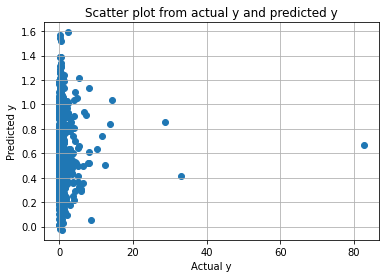

In [12]:
#Model #2:  SGD Regressor set at defaults (max iter = 1000, penalty = "l2", alpha = 0.000, learning_rate = "invscaling")

sgd_reg2_= SGDRegressor()
sgd_reg2_.fit(X_train_scaled, y_train)


y_pred_sgd2=sgd_reg2_.predict(X_val_scaled)
print("mse:",mean_squared_error(y_val, y_pred_sgd2))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred_sgd2)))
print("r-squared:", r2_score(y_val, y_pred_sgd2))
print("training time:", timeit.timeit())

plt.scatter(y_test,y_pred_sgd2)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter plot from actual y and predicted y')
plt.show()

#the r-square is negative, which is not possible. the mse & rmse are off the charts as well.  
#likely because data is not scaled.  data must be scaled to use an sgd.
#after scaling, the results look much better
#good Rsquared and good mse/rmse, but not as good as Model #1 

mse: 2.048244782294969
rmse: 1.431169026458779
r-squared: 0.005934038975777156
training time: 0.01346690000000006


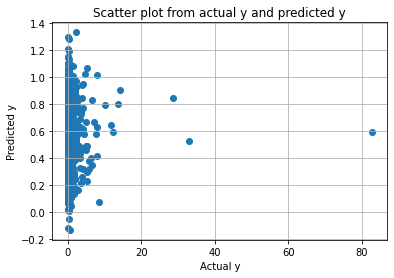

In [13]:
#Model #3:  SGD Regressor  (Changed penalty to l1)

sgd_reg3_= SGDRegressor(max_iter = 1000, penalty = "l1", alpha = 0.0, learning_rate = "invscaling")
sgd_reg3_.fit(X_train_scaled, y_train)


y_pred_sgd3=sgd_reg3_.predict(X_val_scaled)
print("mse:",mean_squared_error(y_val, y_pred_sgd3))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred_sgd3)))
print("r-squared:", r2_score(y_val, y_pred_sgd3))
print("training time:", timeit.timeit())

plt.scatter(y_test,y_pred_sgd3)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter plot from actual y and predicted y')
plt.show()

#good results, but not as good as Model 2 or Model 3

mse: 2.0446709573464146
rmse: 1.429919912913452
r-squared: 0.00766850829444754
training time: 0.019200400000000784


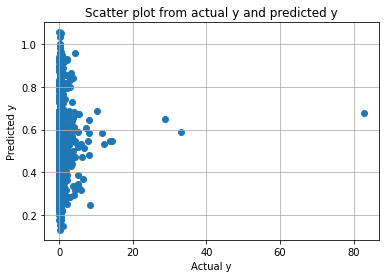

In [14]:
#Model #4:  SGD Regressor  (Changed alpha to 0.5)

sgd_reg4_= SGDRegressor(max_iter = 1000, penalty = "l2", alpha = 0.5, learning_rate = "invscaling")
sgd_reg4_.fit(X_train_scaled, y_train)


y_pred_sgd4=sgd_reg4_.predict(X_val_scaled)
print("mse:",mean_squared_error(y_val, y_pred_sgd4))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred_sgd4)))
print("r-squared:", r2_score(y_val, y_pred_sgd4))
print("training time:", timeit.timeit())

plt.scatter(y_test,y_pred_sgd4)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter plot from actual y and predicted y')
plt.show()

#not as good as other models, poorest model of all

mse: 2.0413628413610603
rmse: 1.4287626959579607
r-squared: 0.009274022207914623
training time: 0.008533299999999855


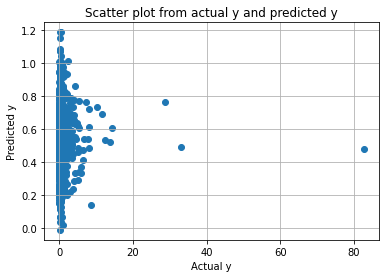

In [15]:
#Model #5:  SGD Regressor s(Changed alpha to 0.5 & learning Rate to Optimal, then had to change max iter to 10K to converge)

sgd_reg5_= SGDRegressor(max_iter = 10000, penalty = "l2", alpha = 0.2, learning_rate = "optimal")
sgd_reg5_.fit(X_train_scaled, y_train)


y_pred_sgd5=sgd_reg5_.predict(X_val_scaled)
print("mse:",mean_squared_error(y_val, y_pred_sgd5))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred_sgd5)))
print("r-squared:", r2_score(y_val, y_pred_sgd5))
print("training time:", timeit.timeit())

plt.scatter(y_test,y_pred_sgd5)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter plot from actual y and predicted y')
plt.show()

#NOT AS bad as model #4

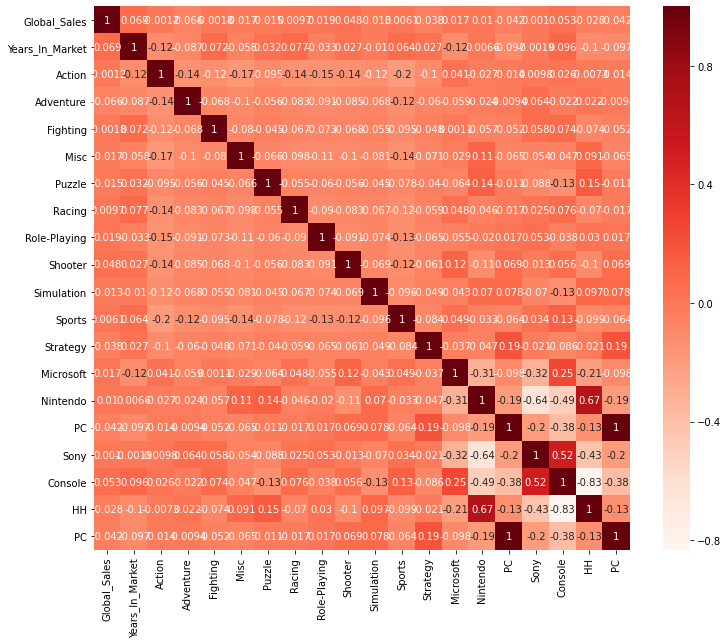

In [16]:
#Filter Method for Feature Selection - select features if 50%+ correlation to Global Sales and remove those with
#multi-collinearity

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = vgsales_df2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [17]:
#Correlation with output variable
cor_target = abs(cor["Global_Sales"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

#these variables are highly relevant to Global Sales
#drop Year_1_Sales because it is a formula we created

Global_Sales    1.0
Name: Global_Sales, dtype: float64

In [18]:
#wrapper method - considered better than filter method bc you add/remove features based on model performance
#backward method = add all possible features and remove iteratively based on perfomance
#performance is defined by p-value, >0.05, we remove

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_train)
#Fitting sm.OLS model
model = sm.OLS(y_train,X_1).fit()
model.pvalues




C:\Users\kyoun\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const              3.201689e-01
Years_In_Market    1.125913e-18
Action             1.158999e-07
Adventure          3.594047e-21
Fighting           4.353918e-07
Misc               2.374246e-11
Puzzle             4.543354e-09
Racing             9.918293e-07
Role-Playing       2.051955e-03
Shooter            8.317407e-02
Simulation         6.070589e-08
Sports             1.131157e-11
Strategy           3.899032e-13
Microsoft          1.046766e-02
Nintendo           6.385839e-03
PC                 5.862527e-03
Sony               1.841044e-02
Console            7.576935e-02
HH                 2.588702e-01
PC                 5.862527e-03
dtype: float64

In [19]:
#Backward Elimination
cols_Xtrain = list(X_train.columns)
print(cols_Xtrain)

cols_X1 = list(X_1.columns)
print(cols_X1)



['Years_In_Market', 'Action', 'Adventure', 'Fighting', 'Misc', 'Puzzle', 'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports', 'Strategy', 'Microsoft', 'Nintendo', 'PC', 'Sony', 'Console', 'HH', 'PC']
['const', 'Years_In_Market', 'Action', 'Adventure', 'Fighting', 'Misc', 'Puzzle', 'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports', 'Strategy', 'Microsoft', 'Nintendo', 'PC', 'Sony', 'Console', 'HH', 'PC']


In [20]:
p = pd.Series(model.pvalues.values[1:])
print(p)
p.shape

0     1.125913e-18
1     1.158999e-07
2     3.594047e-21
3     4.353918e-07
4     2.374246e-11
5     4.543354e-09
6     9.918293e-07
7     2.051955e-03
8     8.317407e-02
9     6.070589e-08
10    1.131157e-11
11    3.899032e-13
12    1.046766e-02
13    6.385839e-03
14    5.862527e-03
15    1.841044e-02
16    7.576935e-02
17    2.588702e-01
18    5.862527e-03
dtype: float64


(19,)

In [21]:
#run the model with the optimal # of features

cols2 = list(X_train.columns)
#best # of  features of model based on result in the next sell
model2 = LinearRegression()
#Initializing RFE model
rfe = RFE(model2, 1)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  
#Fitting the data to model
model2.fit(X_rfe,y_train)
print(rfe.support_)
print(rfe.ranking_)

temp = pd.Series(rfe.support_,index = cols2)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

#recommends EU Sales and not include other features

[False False  True False False False False False False False False False
 False False False False False False False]
[19 10  1  9  6  5 11 12 13  7  8  2 15 18 17 16  3  4 14]
Index(['Adventure'], dtype='object')


In [22]:
#find the optimal # of features

#no of features
nof_list=np.arange(1,30)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model3 = LinearRegression()
    rfe2 = RFE(model3,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_val_rfe = rfe.transform(X_val)
    model3.fit(X_train_rfe,y_train)
    score = model3.score(X_val_rfe,y_val)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 1
Score with 1 features: 0.002629


In [23]:
#embeded feature selection

lasso_reg = LassoCV()
lasso_reg.fit(X_train_scaled, y_train)
print("Best alpha using built-in LassoCV: %f" % lasso_reg.alpha_)
print("Best score using built-in LassoCV: %f" % lasso_reg.score(X,y))
coef = pd.Series(lasso_reg.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.000123
Best score using built-in LassoCV: -0.880439


C:\Users\kyoun\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [24]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 19 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

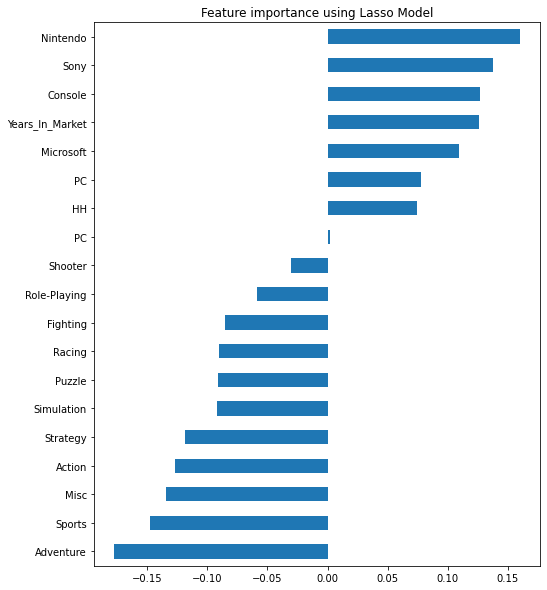

In [25]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

#keep the regional sales only and eliminate other features
#But EU and Other Sales have high multicollinearity with, should only keep NA Sales and JP Sales

In [26]:
print(vgsales_df2[["Nintendo","Sony"]].corr())
print(vgsales_df2[["Console","HH"]].corr())


          Nintendo      Sony
Nintendo  1.000000 -0.641159
Sony     -0.641159  1.000000
          Console        HH
Console  1.000000 -0.832819
HH      -0.832819  1.000000


In [27]:
#permutation importances
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(lin_reg1, X_train, y_train):
    return r2_score(y_train, lin_reg1.predict(X_train))

perm_imp_rfpimp = permutation_importances(lin_reg1, X_train, y_train, r2)

perm_imp_rfpimp

,Importance
Feature,
HH,0.025256
Console,0.019640
Adventure,0.018300
Years_In_Market,0.018122
Misc,0.013694
Action,0.009358
Sports,0.008676
Strategy,0.007369
Nintendo,0.006071
